In [1]:
cd PycharmProjects/motoki_ul/review_analysis

[Errno 2] No such file or directory: 'PycharmProjects/motoki_ul/review_analysis'
/Users/motoki/PycharmProjects/motoki_ul/review_analysis


In [2]:
ls

Review_analysis_instagram.ipynb        Untitled.ipynb
Review_analysis_instagram_mixed.ipynb  input_dir/
Review_analysis_twitter.ipynb          npdict.txt
Review_analysis_twitter_mixed.ipynb    output_dir/
Review_analytics_amazon.ipynb          topic.csv
Review_analytics_lohaco.ipynb


In [7]:
##Clean raw data & prepare for analytics

import pandas as pd

input_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/input_dir/instagram"
df = pd.read_csv(f"{input_dir}/instagram_raw.csv")
df.fillna("。")

#Replace \n in caption (This causes Attribute error on MeCab)
df_new = df
caption = []
for i in df['caption']:
    caption.append(str(i).replace('\n',''))
df_new["caption"] = caption
print(df_new)

#Combine comments on each product (for Doc2Vec)
df_new_combined = df_new.groupby(["id", "hashtag"])["caption"].sum().reset_index()
print(df_new_combined)

       Unnamed: 0                 timestamp   hashtag                 id  \
0               0  2022-06-25T09:00:39+0000   アップルティー  17908393940597411   
1               1  2023-05-11T08:30:00+0000   アップルティー  18331807216072600   
2               2  2023-06-28T22:42:47+0000   アップルティー  17994662491874882   
3               3  2023-05-01T14:33:20+0000   アップルティー  18011534200614305   
4               4  2023-09-02T01:00:11+0000   アップルティー  18055151425456379   
...           ...                       ...       ...                ...   
40093       40093  2023-04-30T11:26:14+0000  フレーバーティー  17985340694092068   
40094       40094  2023-07-08T08:48:27+0000  フレーバーティー  17992288118090880   
40095       40095  2023-08-28T01:24:16+0000  フレーバーティー  17867296865942560   
40096       40096  2021-09-04T02:54:13+0000  フレーバーティー  17902691855181681   
40097       40097  2023-08-22T04:20:29+0000  フレーバーティー  18012879904828938   

           media_type                                 permalink  like_count  \
0      C

In [5]:
##Split into words and visualize

from sklearn.feature_extraction import stop_words
from collections import Counter, defaultdict
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import MeCab
import sys
import urllib
import nltk
import string
import re
import numpy as np

%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic"

tagger = MeCab.Tagger('-Owakati')
tagger.parse(" ")
tagger.parseToNode('ダミー')

class CustomMeCabTagger(MeCab.Tagger):

    COLUMNS = ["表層形", "品詞", "品詞細分類1", "品詞細分類2", "品詞細分類3", "活用型", "活用形", "原形", "読み", "発音"]

    def parseToDataFrame(self, text: str) -> pd.DataFrame:
        """テキストを parse した結果を Pandas DataFrame として返す"""
        results = []
        #Mecabの出力方式に基づく。(表層系\t品詞,品詞細分類...)
        #まずは改行で分けて単語自体を区分する
        text_unlisted = " ".join([i for item in text for i in item])
        for line in self.parse(text_unlisted).split("\n"):
            #EOS = end of statement, no more words
            if line == "EOS":
                break
            #Split word itself and feature by "tab"
            surface, feature = line.split("\t")
            #Put None if the content is "*" (means nothing)
            feature = [None if f == "*" else f for f in feature.split(",")]
            results.append([surface, *feature])
        return pd.DataFrame(results, columns=type(self).COLUMNS)

def get_dokuritsugo_by_mecab(text):
    #tagger = MeCab.Tagger('-Owakati')
    #tagger.parse(" ") 
    node = tagger.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        #only needs below (others don't have meanings in this context)
        if pos in ["名詞", "動詞", "形容詞"]:
            word = node.surface
            word_list.append(word)
        node = node.next
    return " ".join(word_list)

df_new["cleared_words"] = df_new["caption"].apply(lambda x : get_dokuritsugo_by_mecab(x))

stop_words_all = []
#define stopword (English)
nltk.download("stopwords")
stop_words_sklearn = stop_words.ENGLISH_STOP_WORDS
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_nltk.extend(stop_words_sklearn)
stop_words_all = stop_words_nltk

#define stopword (Japanese)
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']
stop_words_all.extend(slothlib_stopwords)

#define manual stopword
add_words=["'",u"それ",u"てる",u"よう",u"こと",u"の",u"し",u"い",u"ん",u"さ",u"て",u"せ",u"れ"]
stop_words_all.extend(add_words)

def del_stop_words(text):
    #replace all the punctuations by using re.sub()
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    sample = regex.sub("", text)
    
    #change to lower case and check if it's in stop words list
    words = [w.lower()  for w in sample.split(" ") \
                 if not w.lower()  in stop_words_all]
    words=" ".join(words)
    return words

def del_single_used_words(text):
    #delete words only used once
    frequency = defaultdict(int)
    for words in text:
        for token in words:
            frequency[token] += 1
    words = [[token for token in words if frequency[token] > 1] for words in text]
    return words

df_new["cleared_stopwords"] = list(df_new["cleared_words"].apply(lambda x: del_stop_words(x)))
text = del_single_used_words([i.split(" ") for i in df_new["cleared_stopwords"]])

##Make combined list for doc2vec (now also used for LDA&word2Vec)
df_new_combined["cleared_words"] = df_new_combined["caption"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"]=list(df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x)))
text_combined = del_single_used_words([i.split(" ") for i in df_new_combined["cleared_stopwords"]])

#finally make dataframe of wordlist splitted by MeCab
tagger = CustomMeCabTagger()
result = tagger.parseToDataFrame(text_combined)

counter_list = []
for i in result["表層形"]:
    counter_list.append(i)
word_count = Counter(counter_list)

df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count = df_count.iloc[1:,:]

print(df_count.head(30))

#Visualization for word count graph
plt.figure(figsize = (30,20))
ax=df_count.iloc[:20,:].plot.bar()
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xticklabels(
    df_count.iloc[:20,:]["word"], fontdict = {
        'fontsize':10})
ax.legend_.remove()
plt.style.use('seaborn-whitegrid')
plt.show()

fpath = "/Users/motoki/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
#Visualization for word cloud
wc_bz = WordCloud(
    background_color="white",
    width=600,
    height=400,
    max_words=3000,
    max_font_size=70,
    font_path=fpath,
    prefer_horizontal=1,
    include_numbers=True,
    colormap='tab20',
    regexp=r"[\w']+")
wc_bz.generate_from_frequencies(word_count)

plt.figure(figsize = (21,12))
#sns.set_style("whitegrid")
plt.imshow(wc_bz, interpolation="bilinear")
plt.axis("off")
plt.style.use('seaborn-whitegrid')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/motoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'NoneType' object has no attribute 'split'

In [5]:
# word frequency output to csv

import datetime

now = datetime.datetime.today()
today = now.strftime("%Y%m%d")
category = str(df_new['hashtag'][1])

output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir"
filename = f"{today}_{category}_instagram.csv"
df_count.to_csv(f"{output_dir}/{filename}")

df_count

,word,count
29,ルイボスティー,3692
154,カフェ,2377
160,好き,1503
177,ティー,1462
158,紅茶,1392
...,...,...
7196,マイボトル,1
5155,詰まっ,1
5725,余,1
5726,計,1


In [6]:
##TF-IDF analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df_new_combined["cleared_words"] = df_new_combined["caption"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"] = df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x))
text_combined_tfidf = [i for i in df_new_combined["cleared_stopwords"]]

vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(text_combined_tfidf)
X=X.toarray()

idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
df_idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
df_idf.columns = ['idf']
display(df_idf.sort_values("idf").head(10).T)

,ルイボスティー,好き,カフェ,ティー,お茶,カフェイン,ある,紅茶,いる,美味しい
idf,1.225647,1.951918,2.096614,2.251763,2.265848,2.354796,2.410587,2.560648,2.629641,2.65026


In [111]:
##t-SNE for TF-IDF
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, verbose=1, n_iter=500)
tsne_tfidf = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 499 samples in 0.106s...
[t-SNE] Computed neighbors for 499 samples in 2.687s...
[t-SNE] Computed conditional probabilities for sample 499 / 499
[t-SNE] Mean sigma: 0.265870
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.000626
[t-SNE] KL divergence after 500 iterations: 1.425384


In [113]:
#Put in DataFrame
df_tsne = pd.DataFrame(tsne_tfidf[:,0],columns = ["x"])
df_tsne["y"] = pd.DataFrame(tsne_tfidf[:,1])
df_tsne["id"]=df_new_combined.id  
df_tsne["hashtag"]=df_new_combined.hashtag

pd.set_option('display.max_rows', 1000)
display(df_tsne.head(10))

,x,y,id,hashtag
0,37.782017,-52.768021,17842330955604797,ルイボスティー
1,-26.983284,11.614927,17844850019598965,ルイボスティー
2,-5.310116,6.617049,17845466726519190,ルイボスティー
3,31.324865,-9.541160,17846089826526605,ルイボスティー
4,10.763801,-20.187702,17846148323612742,ルイボスティー
5,22.252956,-1.945845,17847517487578241,ルイボスティー
6,-3.998441,10.918924,17848690841532373,ルイボスティー
7,-1.994457,13.534575,17849389079518786,ルイボスティー
8,26.993509,0.317667,17849547254516155,ルイボスティー
9,6.783212,-14.940793,17850795761517728,ルイボスティー


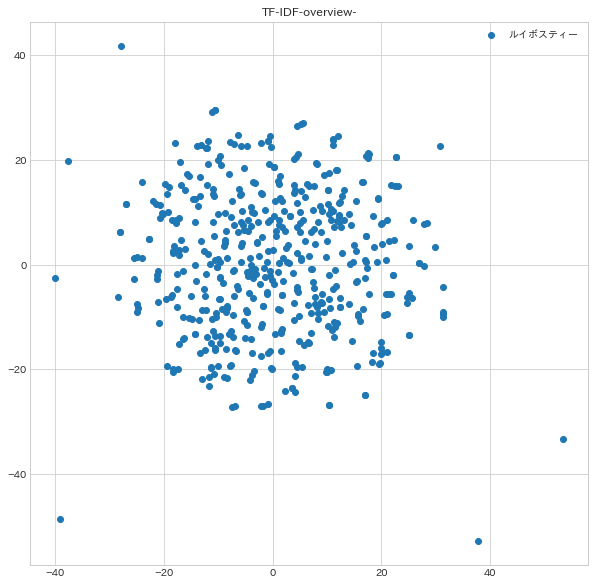

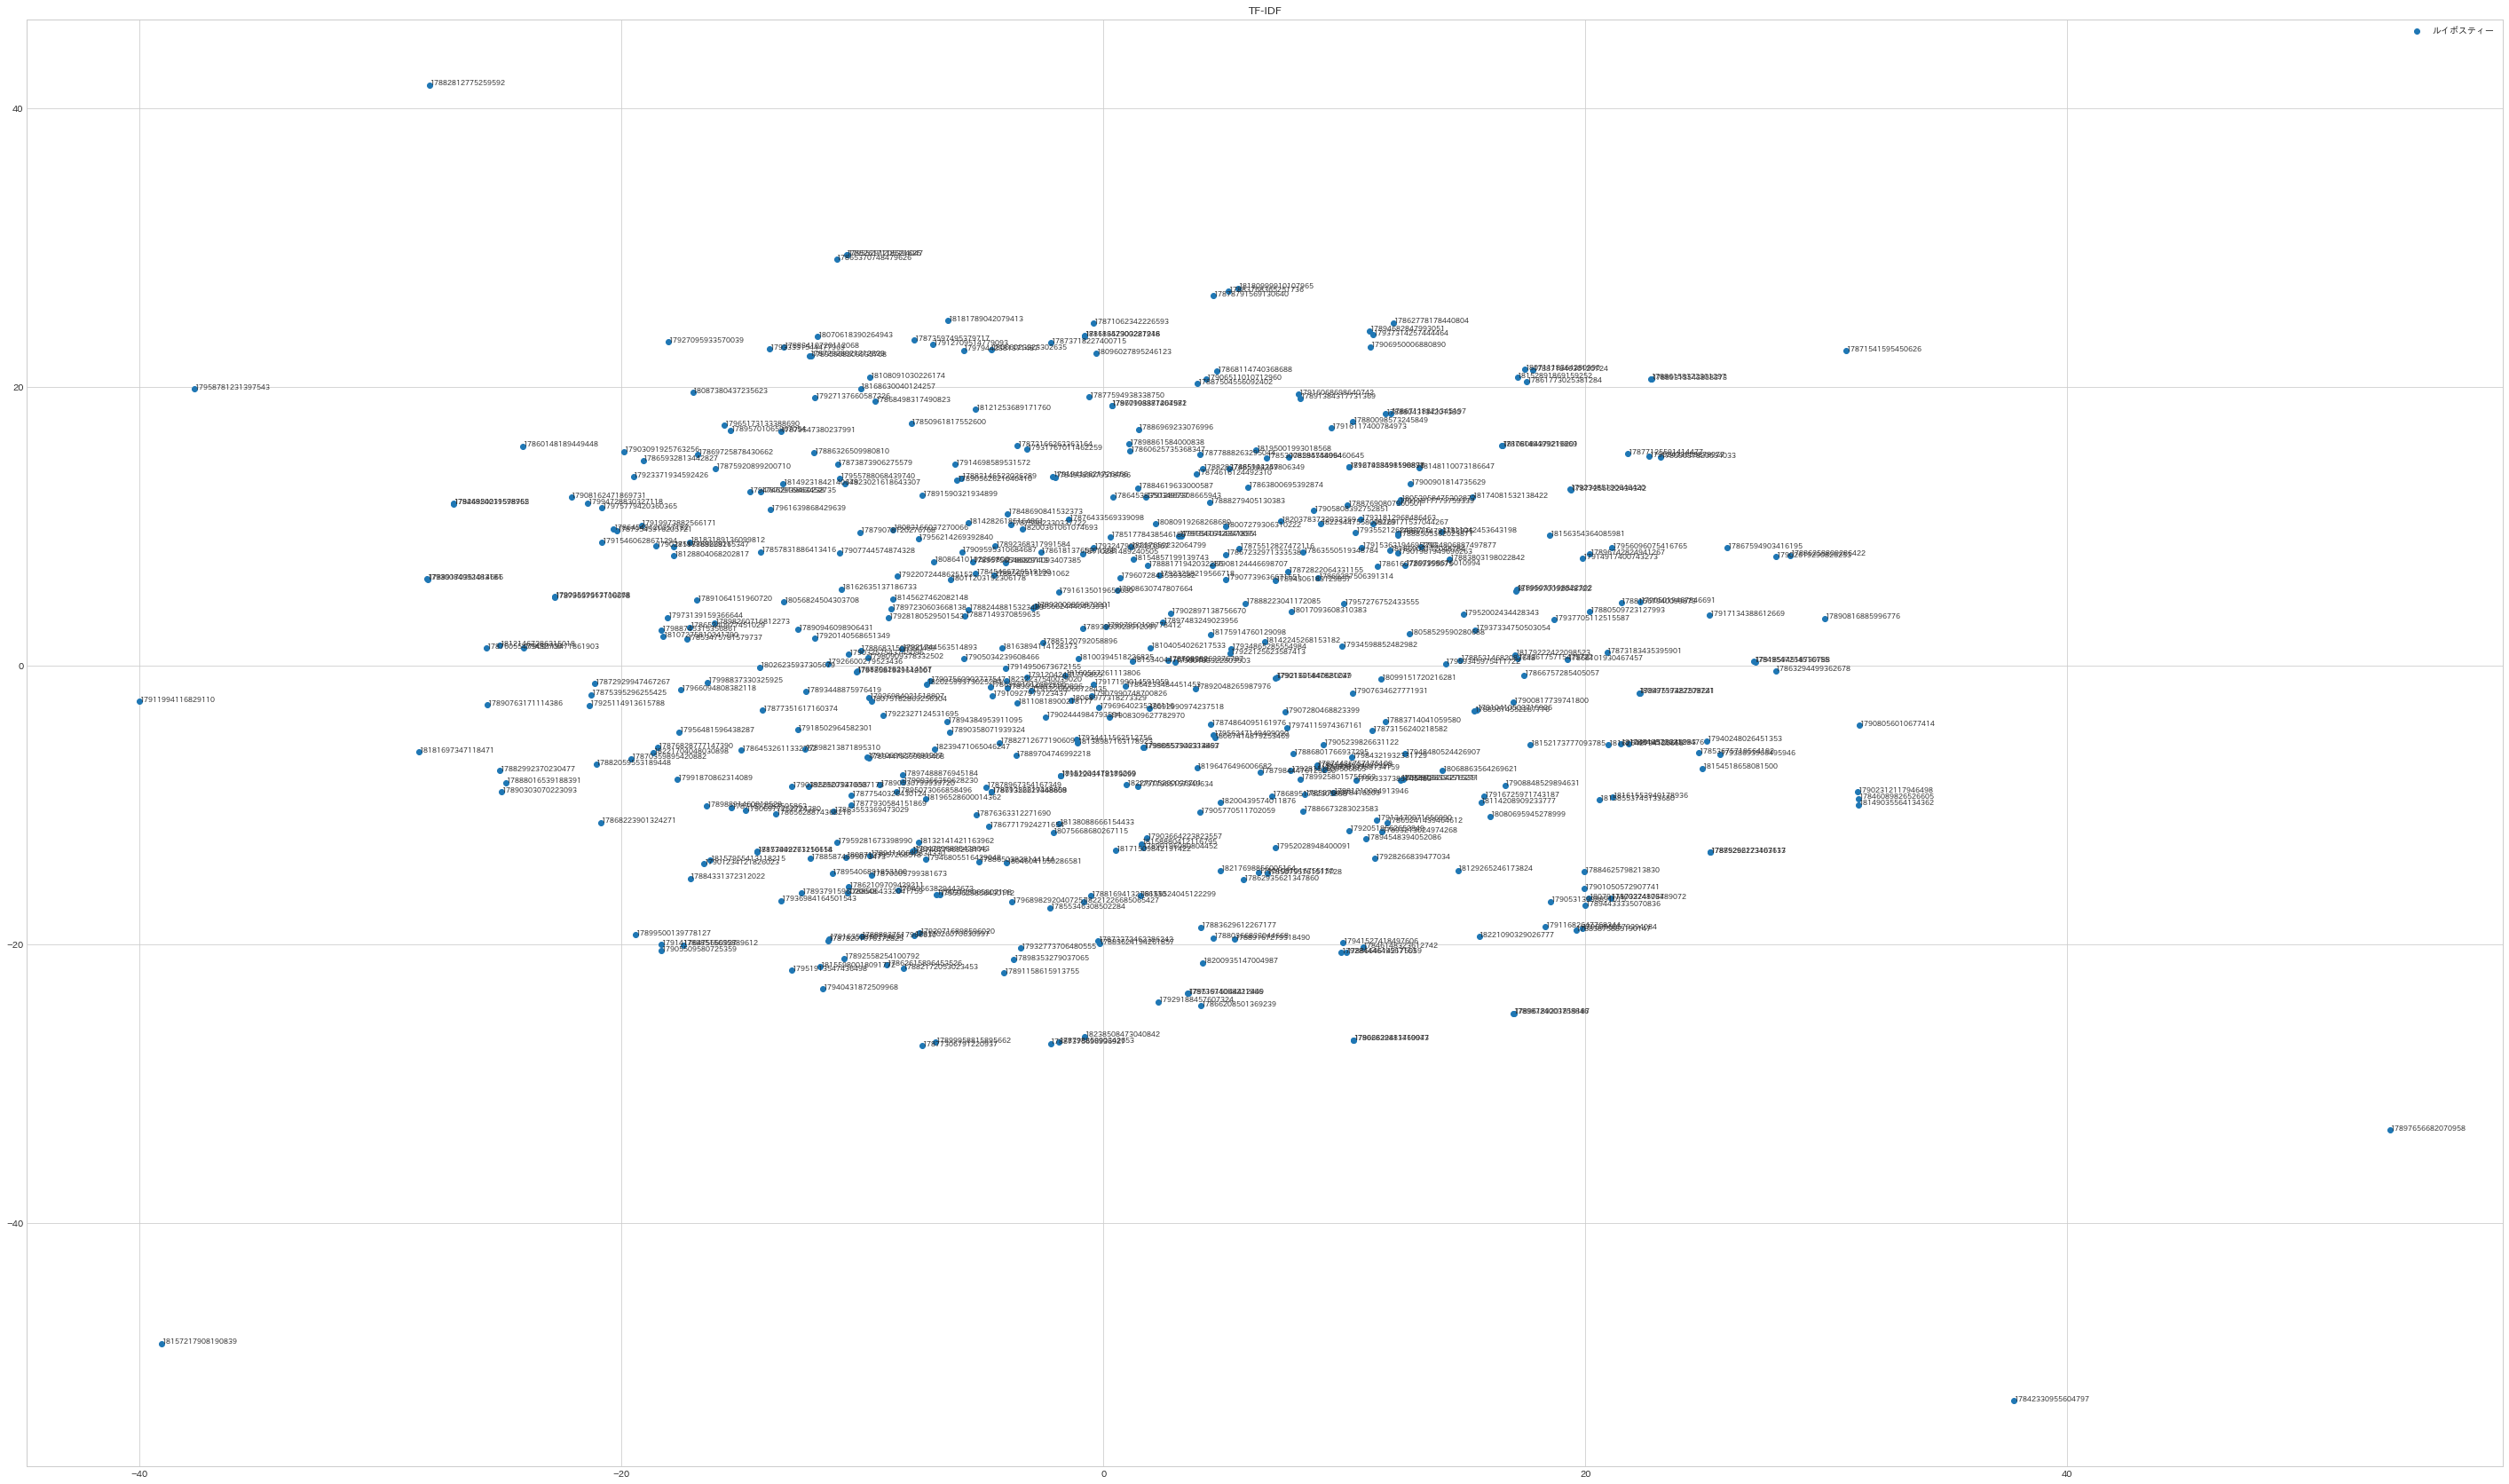

In [116]:
##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne['hashtag'].unique():
    plt.scatter(df_tsne.loc[df_tsne.hashtag == f ,'x'], df_tsne.loc[df_tsne.hashtag == f ,'y'], label=f)

plt.legend()
plt.title("TF-IDF-overview-")
plt.show()

#B: Detail
fig_detail = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne['hashtag'].unique():
    plt.scatter(df_tsne.loc[df_tsne.hashtag== f ,'x'], df_tsne.loc[df_tsne.hashtag == f ,'y'], label=f)

for i, txt in enumerate(df_tsne["id"].values):
    plt.annotate(txt, (df_tsne["x"].values[i], df_tsne["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("TF-IDF")
plt.show()

In [7]:
##LDA analytics (after filtering TF-IDF)

import gensim
from gensim import corpora, models

#Dictionary is the set of "word ID, word, frequency" data (can be saved)
dictionary =corpora.Dictionary(text)
corpus = [dictionary.doc2bow(doc) for doc in text_combined]

#Can filter TF-IDF before LDA
#TF = Term Frequency -> frequency of each word (the bigger, the more important)
#IDF = Inverse document frequency -> filtering too high frequent words like "a, the, there etc.."
#Below is the class for TF-IDF analytics
#tfidf = gensim.models.TfidfModel(corpus)
#corpus_tfidf = tfidf[corpus]

#Number of topics
zk = 5
#Learning model (can be saved)
lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=zk, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000)

for i in range(zk):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)[0:80]+'...'))

tpc_0: 0.222*"" + 0.070*"゙" + 0.014*"カフェ" + 0.012*"゚" + 0.011*"スティー" + 0.011*"ルイホ" + 0....
tpc_1: 0.089*"" + 0.066*"゙" + 0.023*"　" + 0.009*"ルイホ" + 0.009*"゚" + 0.007*"スティー" + 0.00...
tpc_2: 0.246*"" + 0.012*"ルイボスティー" + 0.012*"カフェ" + 0.009*"゙" + 0.008*"好き" + 0.006*"今日" +...
tpc_3: 0.250*"" + 0.017*"ルイボスティー" + 0.013*"ティー" + 0.013*"カフェ" + 0.013*"紅茶" + 0.009*"好き"...
tpc_4: 0.153*"" + 0.034*"ルイボスティー" + 0.007*"オーガニック" + 0.007*"飲ん" + 0.006*"カフェイン" + 0.006...


,id,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Max
0,17842330955604797,0.999616,0.000096,0.000096,0.000096,0.000096,1
1,17844850019598965,0.000674,0.000668,0.680831,0.317152,0.000675,3
2,17845466726519190,0.001660,0.099152,0.001653,0.895858,0.001677,4
3,17846089826526605,0.997537,0.000610,0.000619,0.000619,0.000616,1
4,17846148323612742,0.000838,0.000835,0.101858,0.895633,0.000836,4
5,17847517487578241,0.000858,0.000850,0.996581,0.000859,0.000852,3
6,17848690841532373,0.545758,0.000702,0.000705,0.000711,0.452124,1
7,17849389079518786,0.000521,0.000518,0.000521,0.047119,0.951321,5
8,17849547254516155,0.000193,0.000193,0.000191,0.000190,0.999233,5
9,17850795761517728,0.001784,0.001773,0.313016,0.001791,0.681636,5


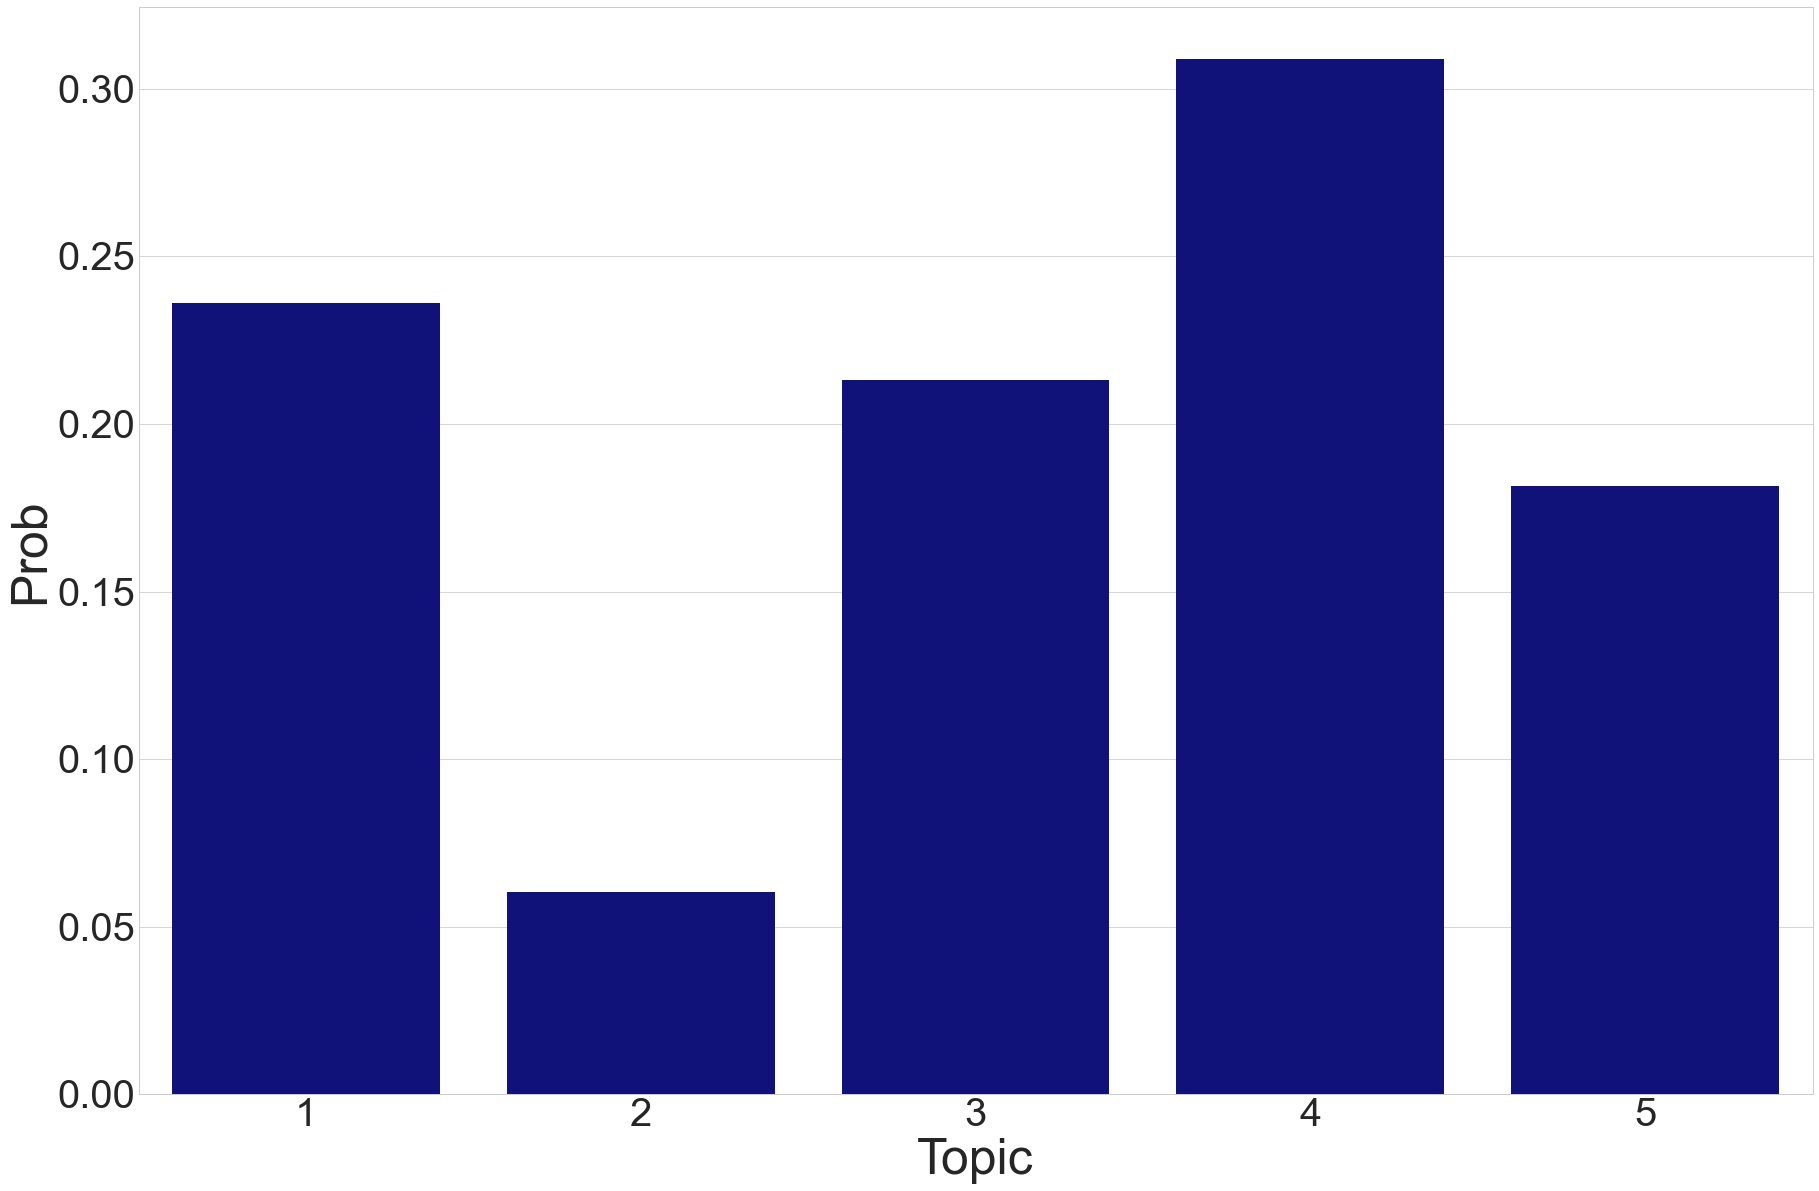

In [8]:
#Make Numpy b/w Products & topics
Prob_products=np.array(lda.get_document_topics(corpus,minimum_probability=0))[:,:,1]

#Put in DataFrame
L=[ z for z in range(1,zk+1)]
col_name=list(map(lambda x: "Prob_"+str(x),L))
df_prob=pd.DataFrame(Prob_products)
df_prob.columns=col_name

#Add product name & most likely belonging topic No.
df_prob["Max"]=df_prob.idxmax(axis=1)
def del_Prob(x):
    return int(x.split("_")[1])
df_prob["Max"]=df_prob["Max"].apply(lambda x : del_Prob(x))
df_prob.insert(0, "id", df_new_combined["id"])
display(df_prob.head(30))

#Calculate probability of apperance of each topic
df_topic=pd.DataFrame(df_prob.drop(["Max", "id"],axis=1).sum()/df_prob.drop(["Max", "id"],axis=1).sum().sum())
df_topic.columns=["Prob"]
df_topic["Topic"]=[ z for z in range(1,zk+1)]

#Visualization
plt.figure(figsize = (30,20))
ax= sns.barplot(x="Topic",y="Prob",data=df_topic,color="darkblue")
ax.set_xlabel("Topic",fontsize=50)
ax.set_ylabel("Prob",fontsize=50)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
plt.show()

<Figure size 1512x864 with 0 Axes>

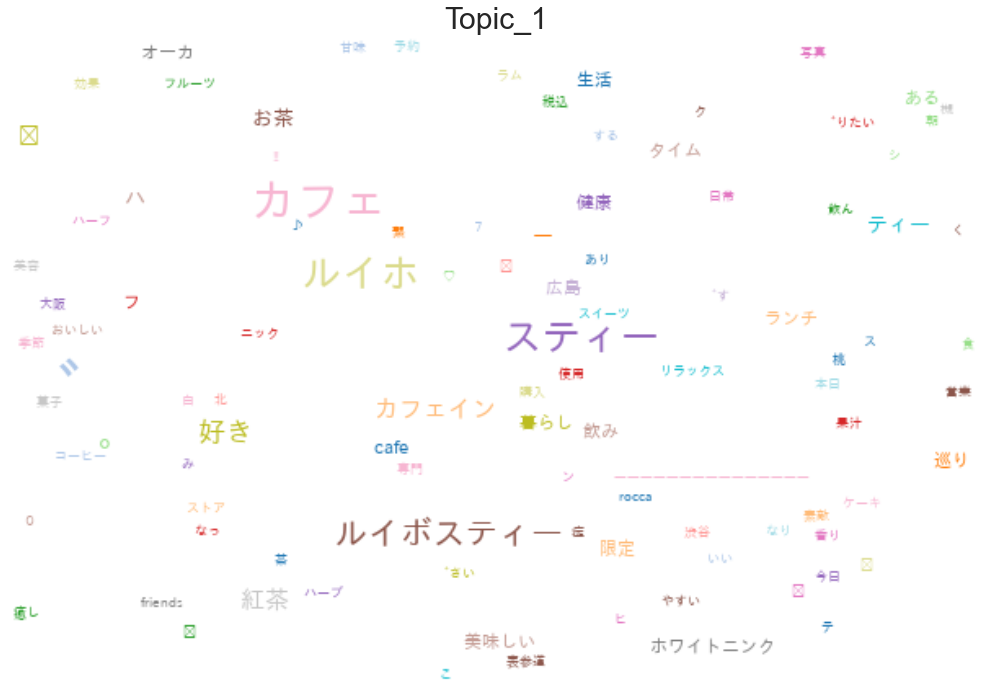

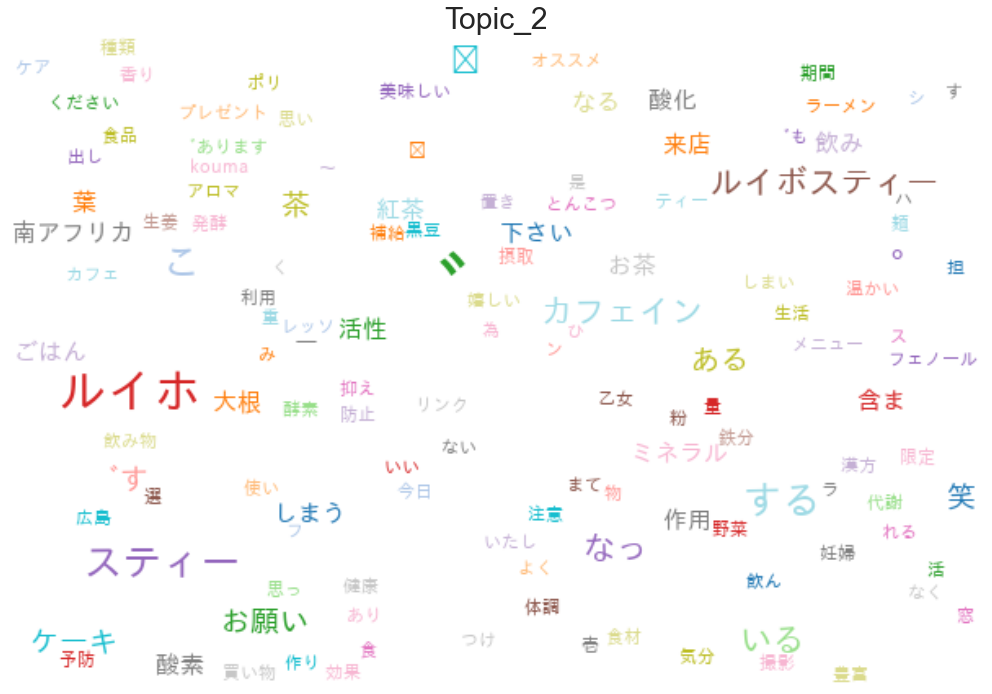

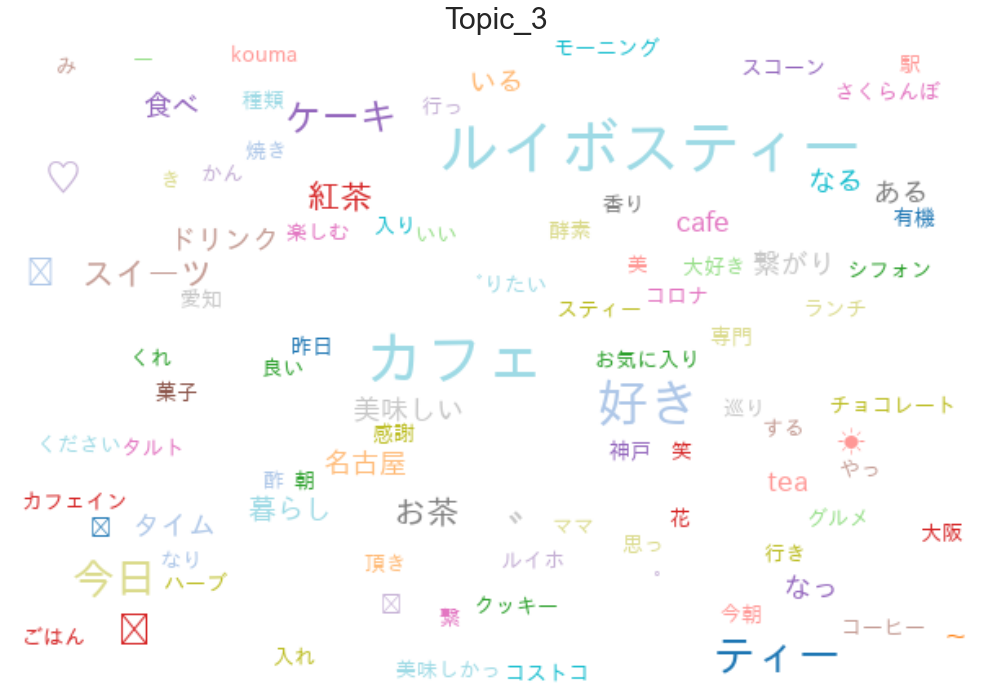

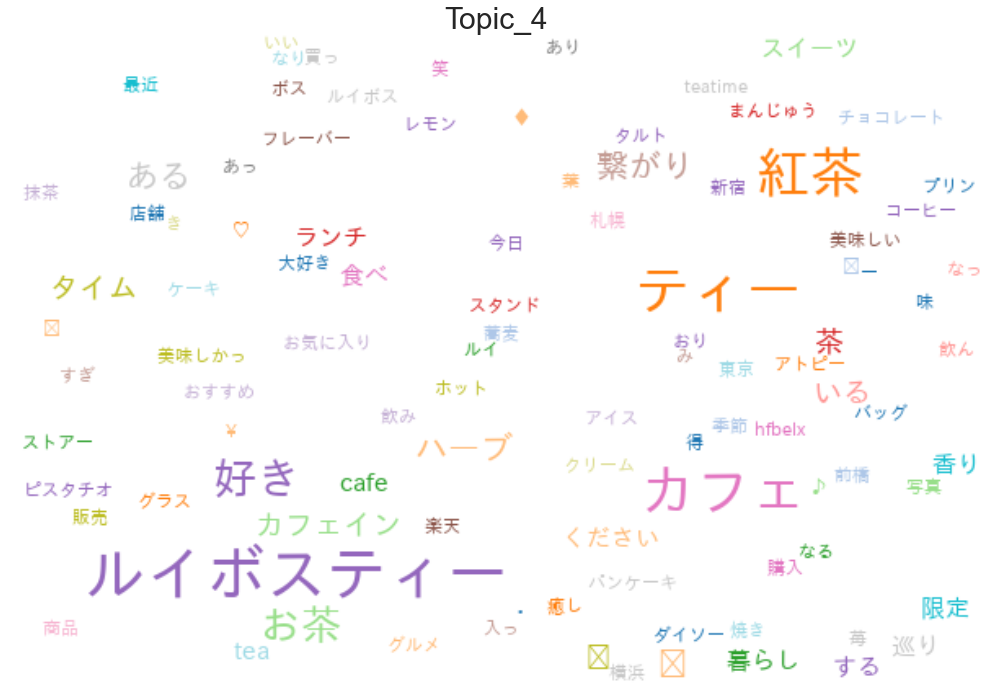

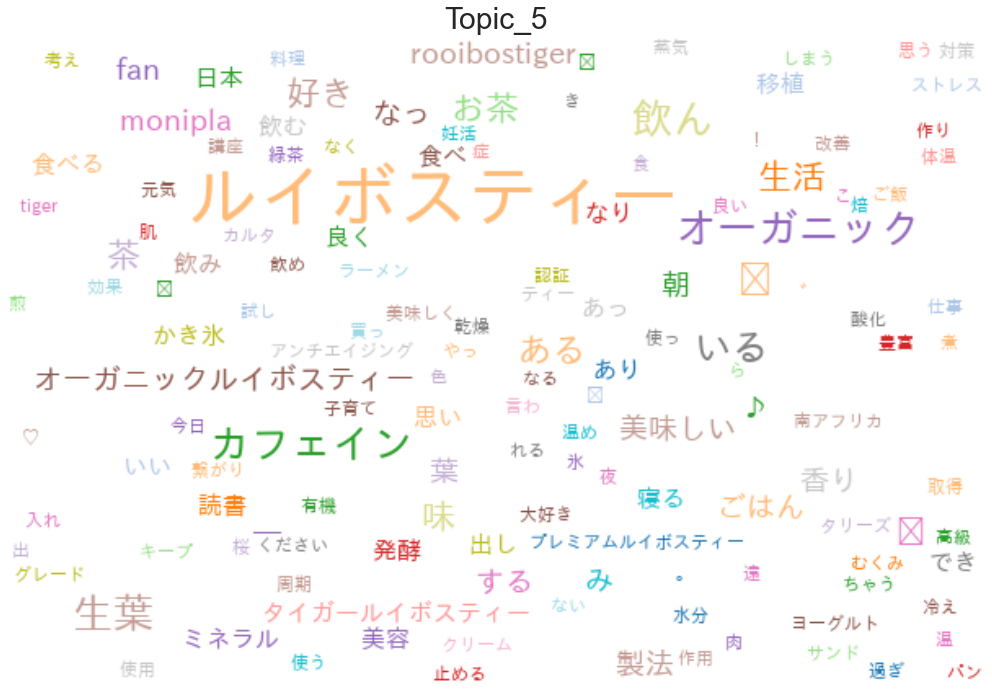

In [9]:
##Visualization of words

topic_word_prob=[]

for z in range(zk):
    word=[]
    prob=[]
    topic = lda.show_topic(z,1000) #No. of words

    for t in topic:
        word.append(t[0])
        prob.append(t[1])
        
    df_lda=pd.DataFrame({"word":word,"prob":prob})
    topic_word_prob.append(df_lda)

fig = plt.figure(figsize=(21, 12))

for z in range(zk):
    topic_text=[]
    for index, row in topic_word_prob[z].iloc[:2000,].iterrows():
        word=row["word"]
        weight=int(row["prob"]*1000)
        for _ in range(weight):
            topic_text.append(word)
            
    words = Counter(topic_text)
    wc_bz = WordCloud(background_color="white",
                      width=600, 
                      height=400, 
                      max_words=3000, 
                      max_font_size=70, 
                      font_path=fpath,
                      prefer_horizontal=1,
                      include_numbers=True,
                      colormap='tab20',
                      regexp=r"[\w']+")
    wc_bz.generate_from_frequencies(words)

    plt.figure(figsize = (21,12))
    sns.set_style("whitegrid")
    plt.title('Topic_{}'.format(z+1), fontsize=30)
    plt.imshow(wc_bz, interpolation='bilinear')
    plt.axis("off")
    
    # topic groups output to png
    output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir"
    pngname =  f"{today}_{category}_{zk}IGtopics"
    plt.savefig(f'{output_dir}/{pngname}_{z+1}.png')
    plt.show()

In [121]:
##Word2Vec Analysis
from gensim.models import word2vec

sent = text_combined
#Learning word2vec model
model = word2vec.Word2Vec(sent,
                          vector_size=50,  # Demention of vector (depends on the number of unique words)
                          min_count=3,  # Words appearing at least 2 times
                          window=5,  # Width of window
                          epochs=4000,  # Iter numbers of leaning
                          seed=2018 # Fix seed for generating stable random number
                         )

KeyboardInterrupt: 

In [46]:
word = "リプトン"
# Output the most similar words & similarity index
results = model.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,トワ,イニング,含ま,毎年,酸味,一番,酸っぱい,ジンジャー,ピーチ,綺麗,清涼,楽しみ,温かい,レモン,最近,はまっ,残念,温まり,向け,強い
Sim,0.503478,0.489715,0.419873,0.326249,0.322715,0.315272,0.295669,0.295229,0.292815,0.283533,0.274624,0.273924,0.257834,0.2556,0.254127,0.248342,0.246455,0.243701,0.224303,0.221184


In [50]:
## Plus/Minus words and show the similarities
results = model.wv.most_similar(positive=[u"ルイボス",u"美味しい"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,子供,ルイボスティー,飲み,少なく,母,バニラ,健康,なる,１,酸っぱ,入っ,いる,ルイボスティ,口コミ,でき,思い,水筒,種類,注ぐ,作る
Sim,0.491984,0.428961,0.363454,0.339553,0.327391,0.296987,0.286571,0.282587,0.280377,0.276089,0.261365,0.254071,0.25315,0.239916,0.239635,0.230769,0.228517,0.21024,0.207163,0.206145


In [54]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.id[i])
    feature_vec = np.zeros(50)
    num_words = 0
    for word in product:
        try:
            feature_vec += model.wv[word]
            num_words += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec = feature_vec / num_words  # Split sum of all the words vector
    product_vec[i] = feature_vec

##t-SNE for Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_word2vec = tsne.fit_transform(product_vec)

DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　1箱（6個入）
LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートティー 1個（1.5g～2g×20袋） ハーブティー
LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー
Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）
【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイン フルーツ入り ］
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメロン 52504 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 52500 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g×3個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティーイチジク 52506 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみつシナモン 52510 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ 52512 50g1個
【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）
【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）
【ノンカフェイン】　国太楼　ルイボスティー　1袋（10

,x,y,product_name,brand
0,15.421871,-32.642307,DEAN&DELUCA（ディーンアンドデルーカ） ティーセレクション ハーバル&フレーバー ...,ディーン＆デルーカ
1,13.768413,24.291910,LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...,SONNENTOR（ゾネントア）
2,18.572802,5.938023,LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー,LEBENSBAUM（レーベンスバウム）
3,10.622675,-29.100092,Wismettacフーズ セレッシャル スリーピータイム 1箱（20バッグ入）,セレッシャルシーズニングス
4,13.246469,9.407538,Wismettacフーズ セレッシャル ハニーバニラカモミール 1箱（20バッグ入）,セレッシャルシーズニングス
5,4.146376,10.501554,Wismettacフーズ セレッシャル ハーブ5種アソートセット 1箱（18バッグ入）,セレッシャルシーズニングス
6,10.620839,-17.488949,【 ハーブティー 】 フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...,Fruit Garden（フルーツガーデン）
7,4.419537,-22.490021,【 ハーブティー 】 フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...,Fruit Garden（フルーツガーデン）
8,28.651991,-12.408365,【 ハーブティー 】 フルーツガーデン ブラッドオレンジ 1袋 125g ［ ノンカフェイ...,Fruit Garden（フルーツガーデン）
9,-25.450825,-30.221359,【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...,VECUA Honey（ベキュアハニー）


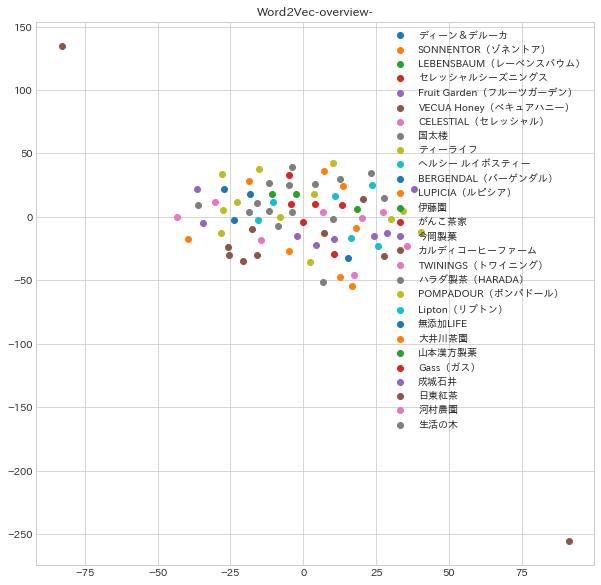

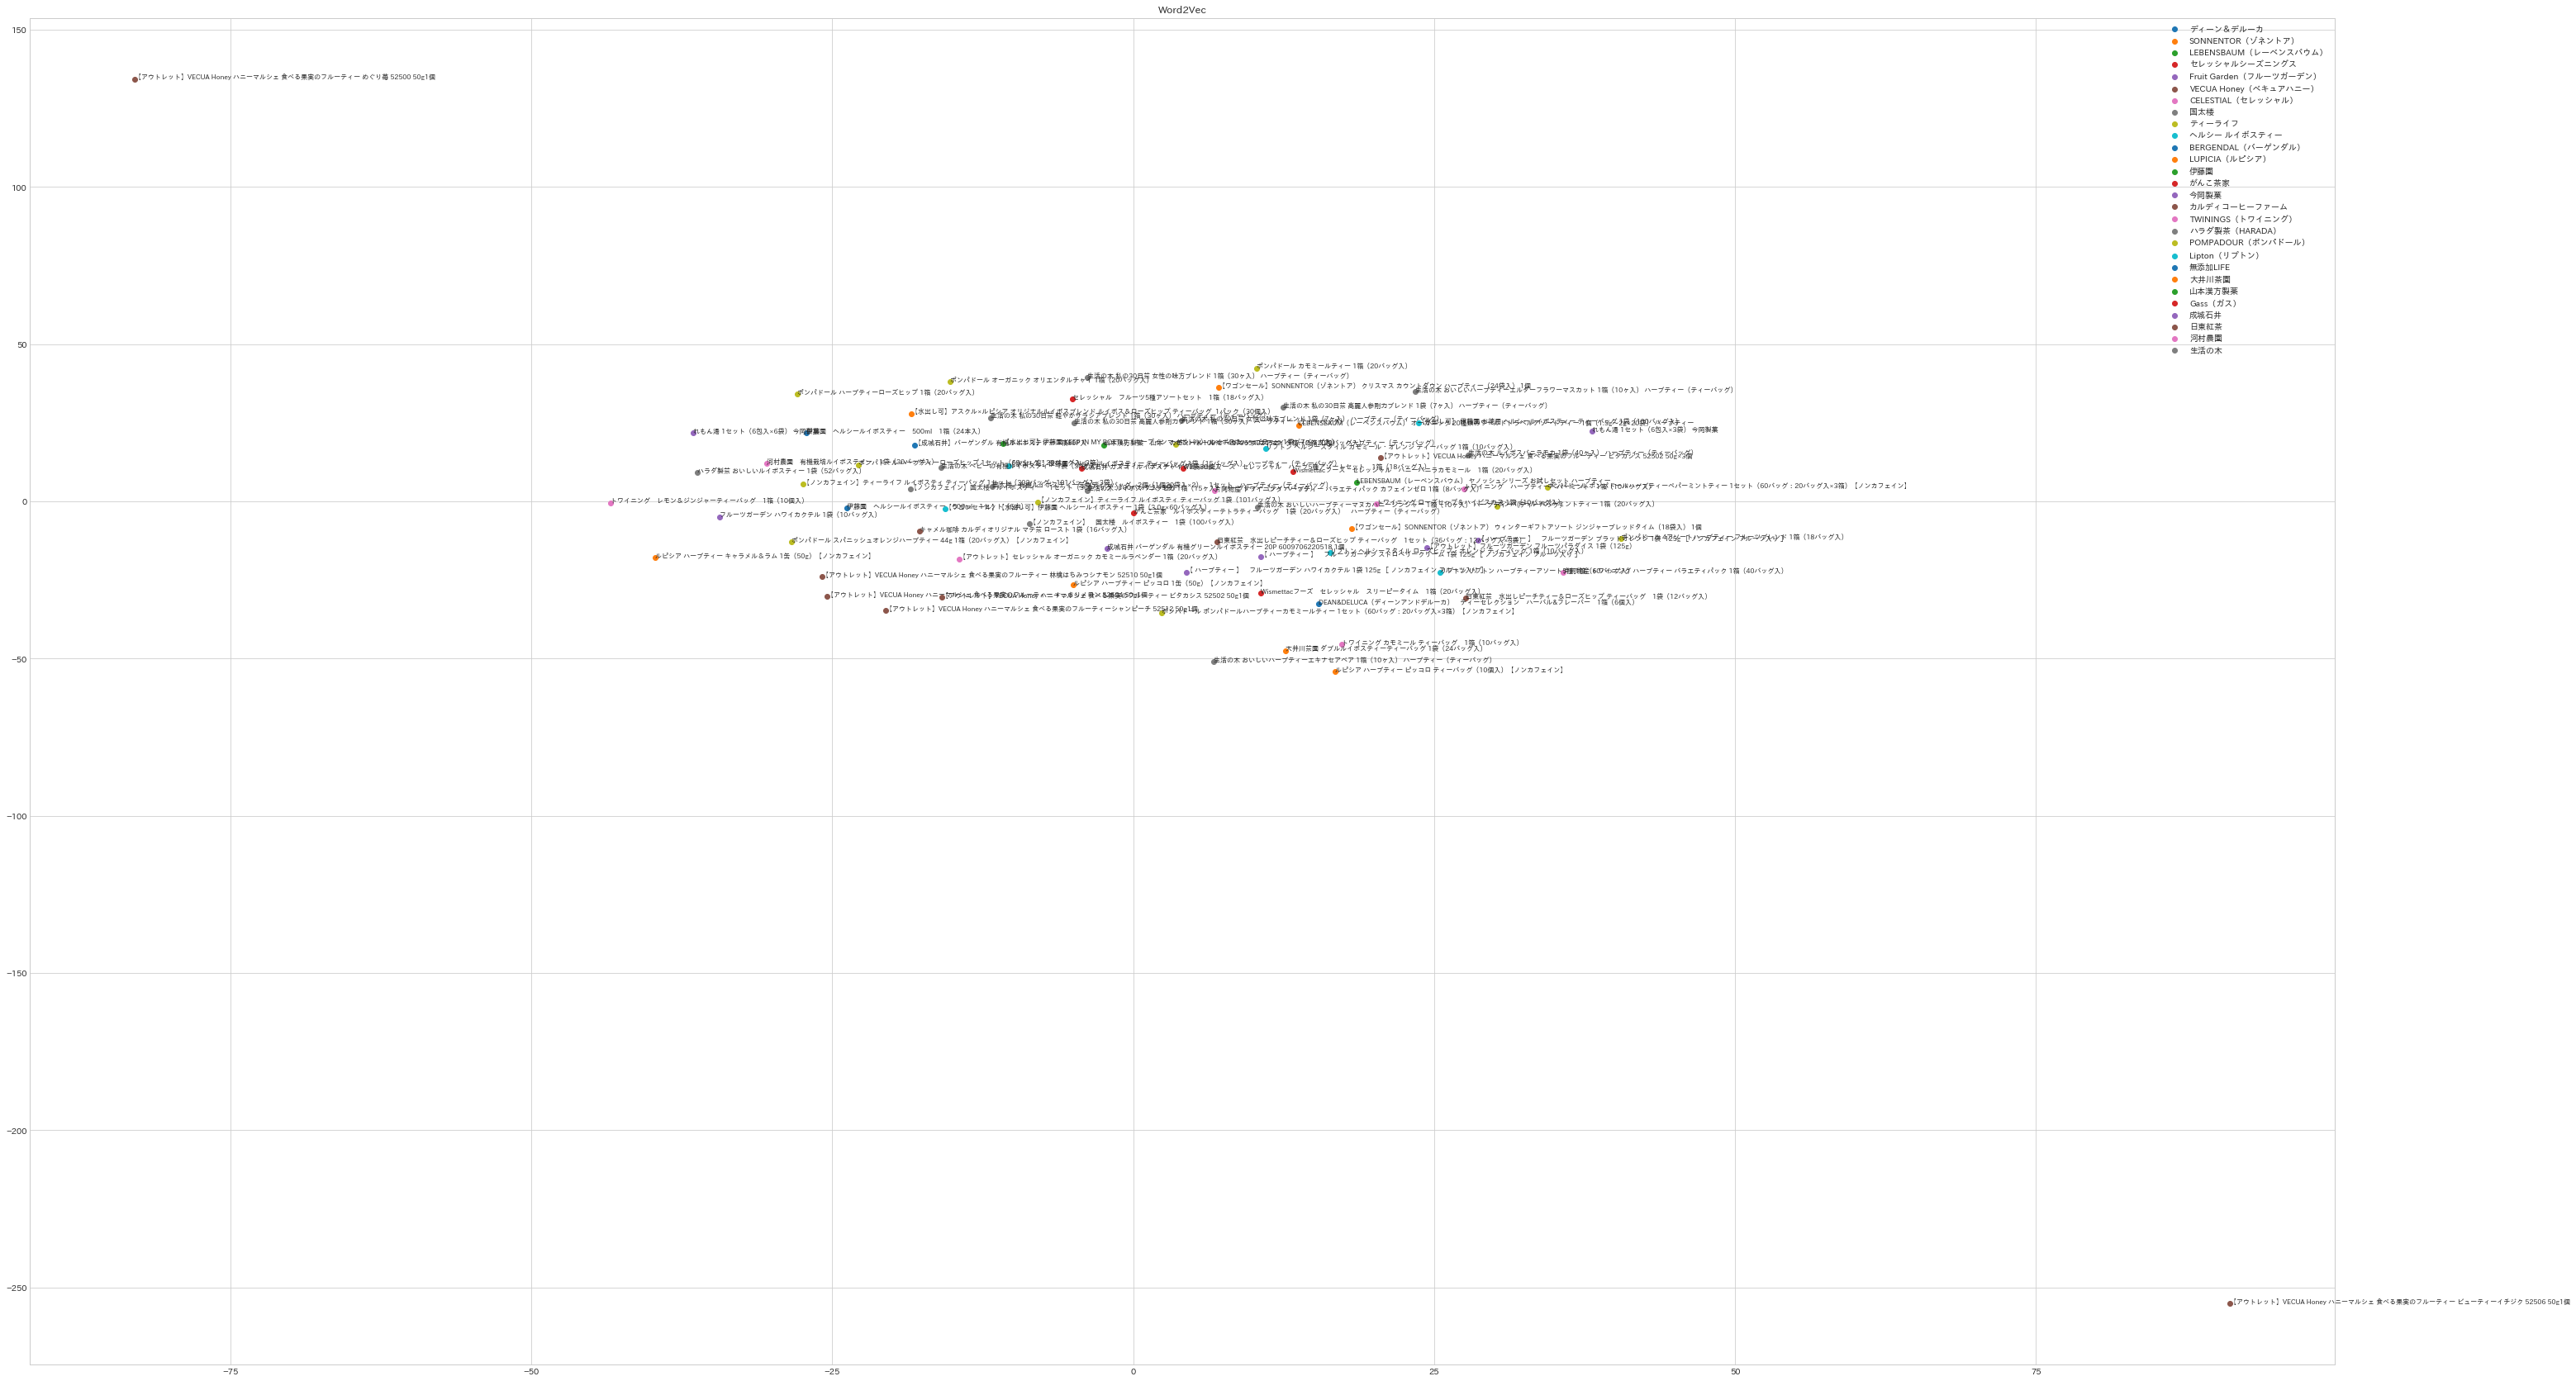

In [56]:
#Put in DataFrame
df_tsne_word2vec = pd.DataFrame(tsne_word2vec[:, 0],columns = ["x"])
df_tsne_word2vec["y"] = pd.DataFrame(tsne_word2vec[:, 1])
df_tsne_word2vec["id"] = df_new_combined.id
df_tsne_word2vec["hashtag"] = df_new_combined.hashtag

pd.set_option('display.max_rows', 1000)
display(df_tsne_word2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_word2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_word2vec['hashtag'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.hashtag == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.hashtag == f ,'y'], label=f)

plt.legend()
plt.title("Word2Vec-overview-")

#B: Detail
fig_detail_word2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_word2vec['hashtag'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.hashtag == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.hashtag == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_word2vec["id"].values):
    plt.annotate(txt, (df_tsne_word2vec["x"].values[i], df_tsne_word2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Word2Vec")

plt.show()

In [1]:
##Doc2Vec analysis

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora, models

trainings_combined = [TaggedDocument(words=data, tags=[name]) for (name, data) in zip(df_new_combined["id"], text_combined)]

# Learning model
model_doc_combined = models.Doc2Vec(
    documents=trainings_combined,
    vector_size=50,
    min_count=2,
    epochs=4000
)

/Users/motoki/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


NameError: name 'df_new_combined' is not defined

In [58]:
word = "リプトン"
# Output the most similar words & similarity index
results = model_doc_combined.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,トワ,温かい,イニング,一番,気に入っ,綺麗,購入,思い,安かっ,癒さ,毎年,異国,効い,美味しく,母,濃く,０,かわいい,向け,暑い
Sim,0.535167,0.441997,0.42409,0.359616,0.35638,0.355789,0.332568,0.31348,0.302193,0.300955,0.299515,0.297638,0.291877,0.284169,0.28322,0.278115,0.27741,0.259111,0.250586,0.249902


In [59]:
## Plus/Minus words and show the similarities
results = model_doc_combined.wv.most_similar(positive=[u"リプトン",u"安い"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,香り,トワ,コス,癒さ,毎年,気に入っ,綺麗,思い,定期,安心,購入,向け,はまっ,飲む,イニング,パッケージ,でる,感想,お茶,母
Sim,0.372038,0.358927,0.339417,0.338398,0.334616,0.324355,0.319897,0.317904,0.307789,0.302372,0.288592,0.288399,0.281103,0.277634,0.275786,0.27345,0.260004,0.258803,0.25166,0.251638


In [61]:
## Find similar items(documents)
results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

<ipython-input-61-b771ea8573ae>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")


,0,1,2,3,4,5,6,7,8,9
Word,ポンパドール カモミールティー 1箱（20バッグ入）,伊藤園 ヘルシールイボスティー 500ml 1箱（24本入）,ポンパドール ハーブティーローズヒップ 1セット（60バッグ：20バッグ入×3箱）,山本漢方製薬 山本 カモミール100% 4979654024549 1箱（2g×20包） ハ...,生活の木 私の30日茶 女性の味方ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）,【 ハーブティー 】 フルーツガーデン ブラッドオレンジ 1袋 125g ［ ノンカフェイ...,ルピシア ハーブティー キャラメル＆ラム 1缶（50g）【ノンカフェイン】,生活の木 私の30日茶 高麗人参剛力ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）,生活の木 ルイボスバニラモカ 1袋（40ヶ入） ハーブティー（ティーバッグ）,ポンパドール ポンパドールハーブティーカモミールティー 1セット（60バッグ：20バッグ入×...
Sim,0.54276,0.501323,0.492985,0.47014,0.45922,0.45398,0.45277,0.448062,0.440716,0.436387


In [48]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec_doc = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.id[i])
    feature_vec_doc = np.zeros(50)
    num_words_doc = 0
    for word in product:
        try:
            feature_vec_doc += model_doc_combined.wv[word]
            num_words_doc += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec_doc = feature_vec_doc / num_words_doc  # Split sum of all the words vector
    product_vec_doc[i] = feature_vec_doc

##t-SNE for Doc2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_doc2vec = tsne.fit_transform(product_vec_doc)

DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　1箱（6個入）
LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートティー 1個（1.5g～2g×20袋） ハーブティー
LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー
Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）
【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイン フルーツ入り ］
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメロン 52504 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 52500 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g×3個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティーイチジク 52506 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみつシナモン 52510 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ 52512 50g1個
【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）
【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）
【ノンカフェイン】　国太楼　ルイボスティー　1袋（10

,x,y,product_name,brand
0,-45.109653,79.046638,DEAN&DELUCA（ディーンアンドデルーカ） ティーセレクション ハーバル&フレーバー ...,ディーン＆デルーカ
1,12.106108,1.592252,LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...,SONNENTOR（ゾネントア）
2,17.036133,11.622809,LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー,LEBENSBAUM（レーベンスバウム）
3,24.627947,22.885389,Wismettacフーズ セレッシャル スリーピータイム 1箱（20バッグ入）,セレッシャルシーズニングス
4,2.782181,10.985058,Wismettacフーズ セレッシャル ハニーバニラカモミール 1箱（20バッグ入）,セレッシャルシーズニングス
5,-8.521563,-69.922462,Wismettacフーズ セレッシャル ハーブ5種アソートセット 1箱（18バッグ入）,セレッシャルシーズニングス
6,-37.420597,3.177659,【 ハーブティー 】 フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...,Fruit Garden（フルーツガーデン）
7,87.071495,38.387630,【 ハーブティー 】 フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...,Fruit Garden（フルーツガーデン）
8,-68.426849,27.638330,【 ハーブティー 】 フルーツガーデン ブラッドオレンジ 1袋 125g ［ ノンカフェイ...,Fruit Garden（フルーツガーデン）
9,51.686825,-58.242813,【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...,VECUA Honey（ベキュアハニー）


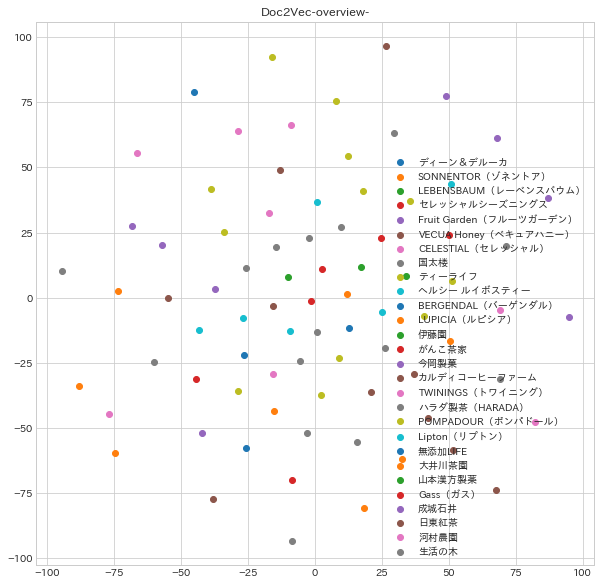

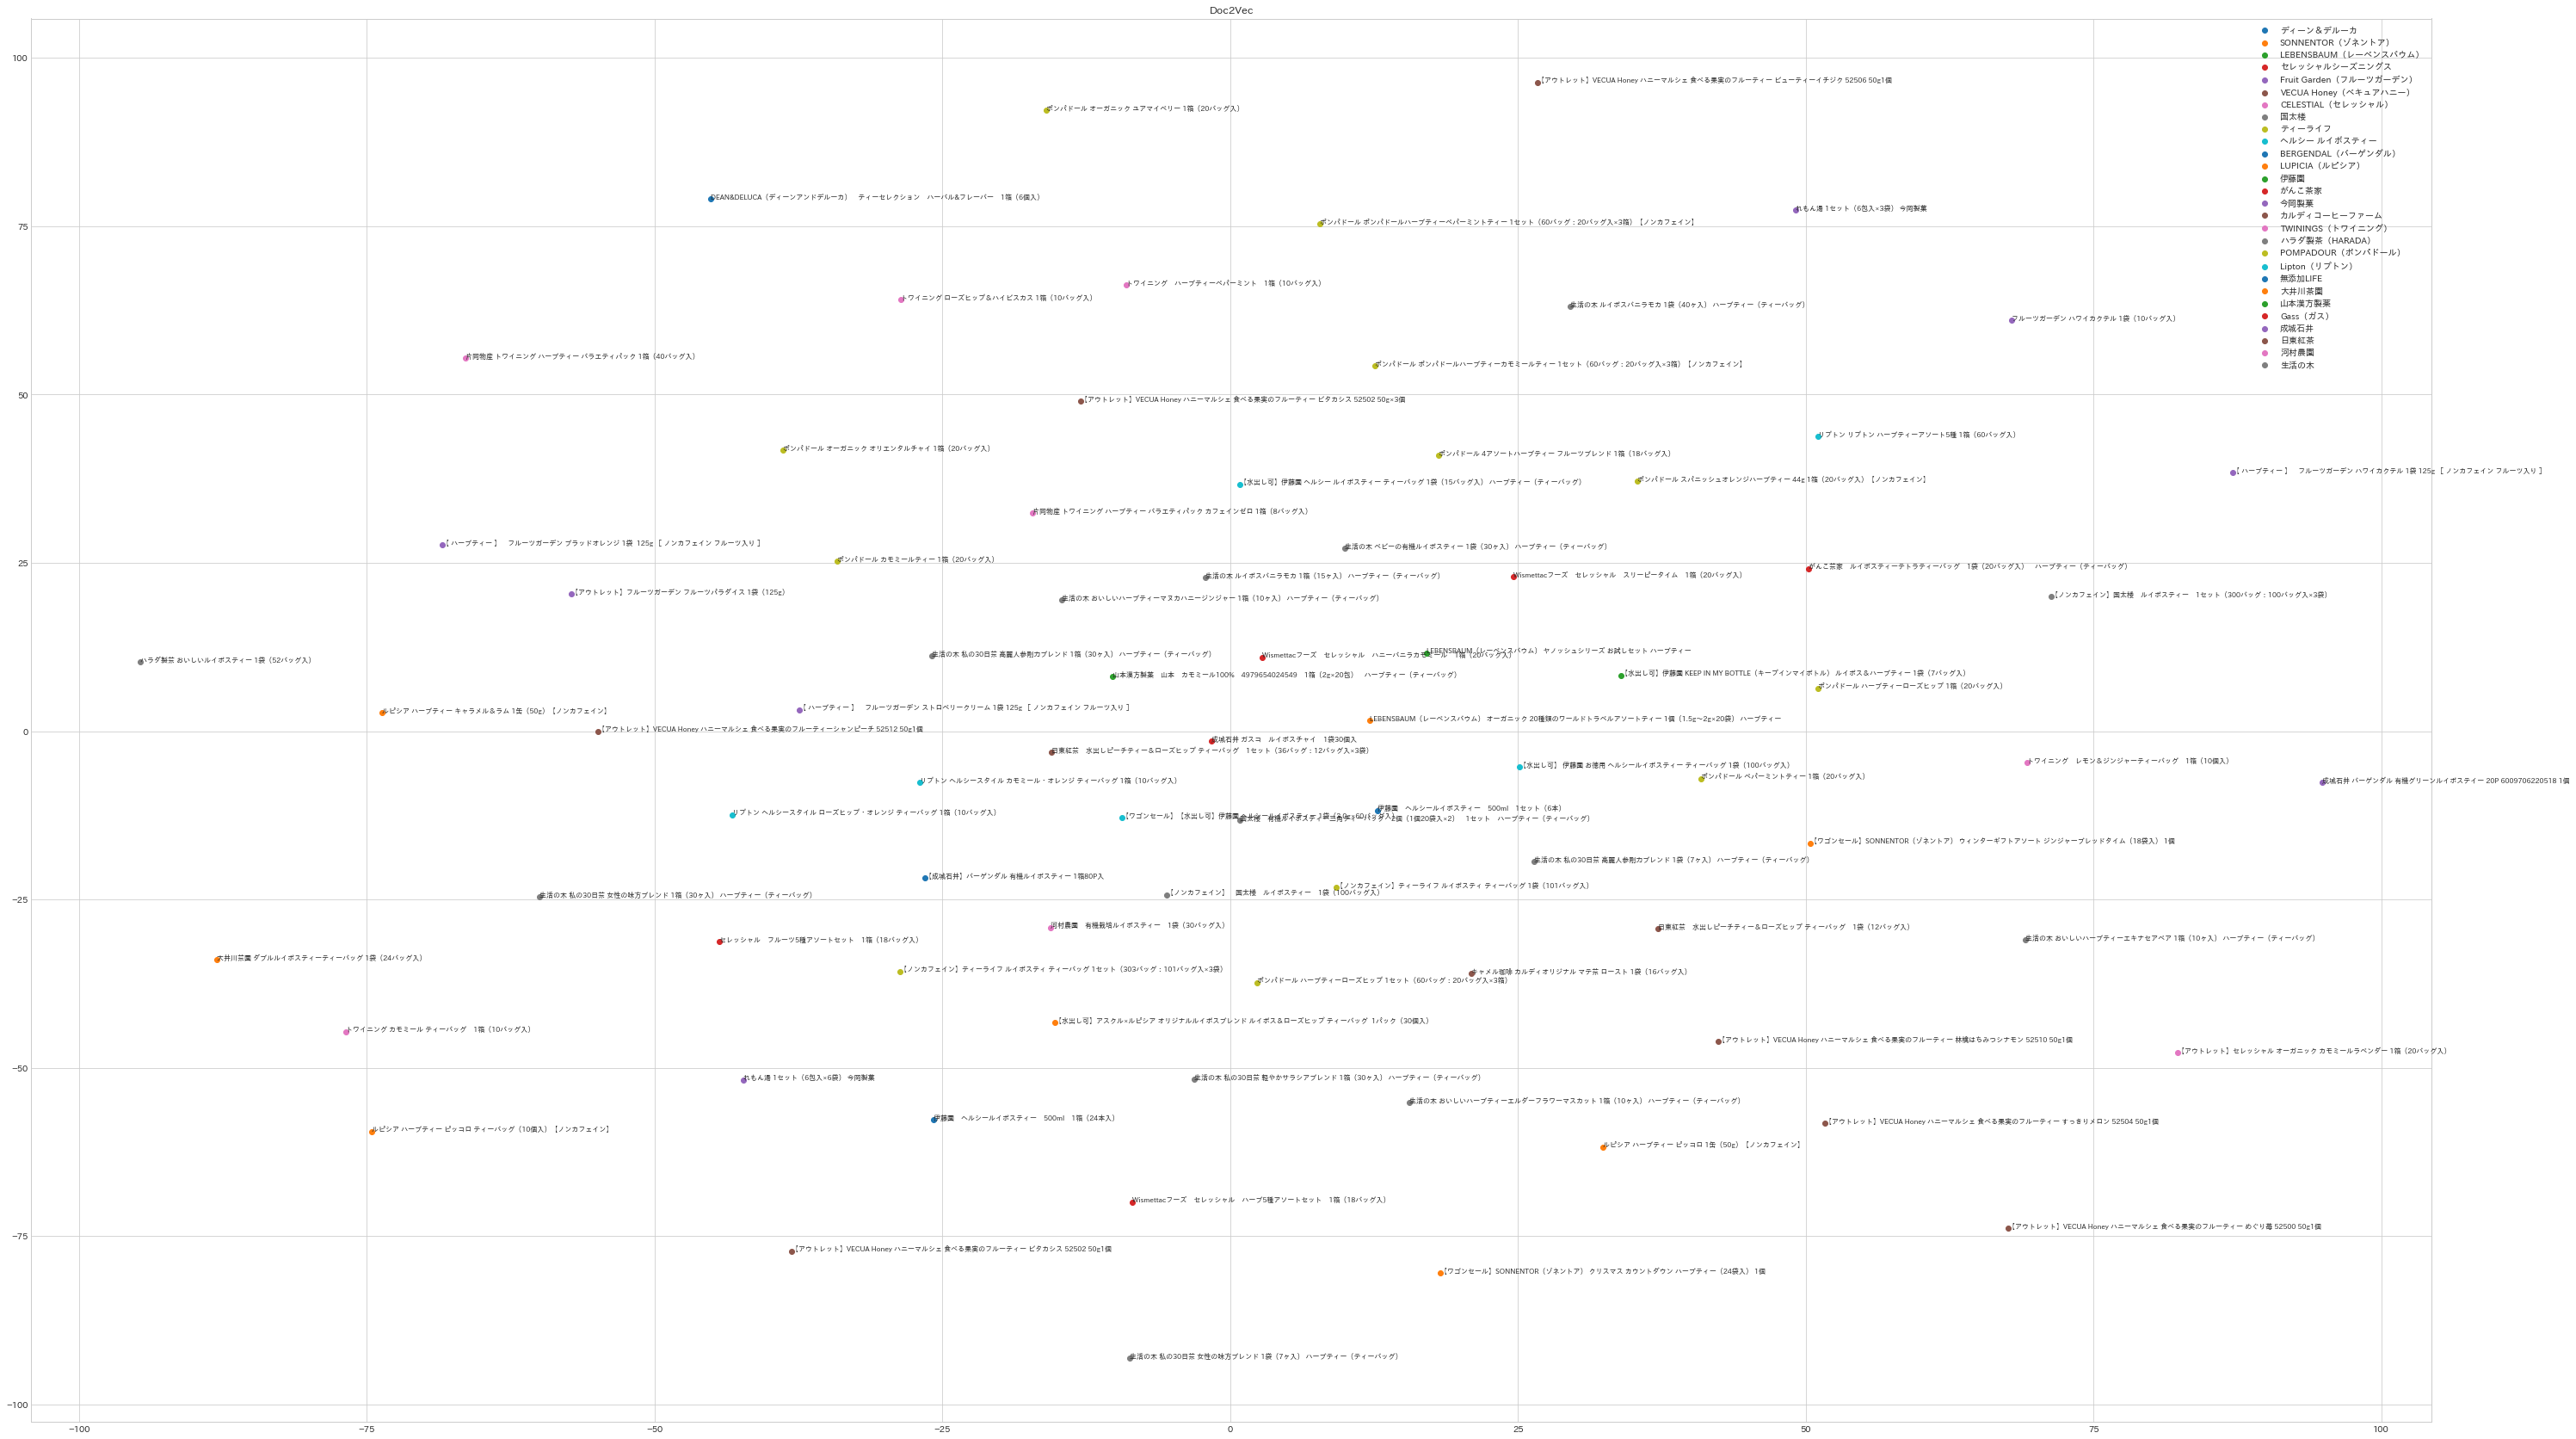

In [62]:
#Put in DataFrame
df_tsne_doc2vec = pd.DataFrame(tsne_doc2vec[:, 0],columns = ["x"])
df_tsne_doc2vec["y"] = pd.DataFrame(tsne_doc2vec[:, 1])
df_tsne_doc2vec["id"] = df_new_combined.id
df_tsne_doc2vec["hashtag"] = df_new_combined.hashtag

pd.set_option('display.max_rows', 1000)
display(df_tsne_doc2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_doc2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_doc2vec['hashtag'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.hashtag == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.hashtag == f ,'y'], label=f)

plt.legend()
plt.title("Doc2Vec-overview-")

#B: Detail
fig_detail_doc2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_doc2vec['hashtag'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.hashtag == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.hashtag == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_doc2vec["id"].values):
    plt.annotate(txt, (df_tsne_doc2vec["x"].values[i], df_tsne_doc2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Doc2Vec")

plt.show()